In [16]:
import io
import os
import platform
import pdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import cm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

In [17]:
data=pd.read_csv('shenyang.csv')
dataset=data.iloc[:,-1]
dataset.replace(9999,np.nan,inplace=True)
dataset.replace(-999,np.nan,inplace=True)
for i in range(len(data)):
    if np.isnan(dataset.iat[i]):
        if i==0:
            dataset.iloc[i]=dataset.iat[i+1]
        elif i==len(data)-1:
            dataset.iloc[i]=dataset.iat[i-1]
        else:
            dataset.iloc[i]=np.nanmean([dataset.iat[i-1],dataset.iat[i+1]])

In [18]:
type(dataset)

pandas.core.series.Series

In [19]:
scaler = preprocessing.MinMaxScaler() 
scaled_values = scaler.fit_transform(pd.DataFrame(dataset))
# dataset.iloc[:] = np.squeeze(scaled_values)

In [20]:
data_set=np.asarray(dataset,dtype=np.float32)
seq_len=30 + 1
x=len(data_set)-seq_len
sequences = [data_set[t:t+seq_len] for t in range(x)]
for i in range(len(sequences)):
    sequences[i]=scaler.fit_transform(sequences[i].reshape(-1,1))
seq=torch.FloatTensor(sequences)

In [21]:
split_row=round(0.90*seq.size(0))
x_train_set=seq[:split_row, :-1]
y_train_set=seq[:split_row, -1]
x_valid_set=seq[split_row:, :-1]
y_valid_set=seq[split_row:, -1]

In [22]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=2,dropout=0,bidirectional=False):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.dropout=dropout
        self.bidirectional=bidirectional
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            dropout=dropout,
                            bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size, input_size)
        
    def forward(self,inputs,hidden):
        outputs,hidden=self.lstm(inputs,hidden)
        predictions=self.linear(outputs[-1])
        return predictions,outputs,hidden
    
    def init_hidden(self,batch_size):
        num_directions=2 if self.bidirectional else 1
        hidden = (torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size),
                  torch.zeros(self.num_layers*num_directions, batch_size, self.hidden_size))
        return hidden

In [23]:
def get_batch(x,y,i,batch_size):
    if x.dim() == 2:
        x = x.unsqueeze(2)
    batch_x = x[(i*batch_size):(i*batch_size)+batch_size, :, :]
    batch_y = y[(i*batch_size):(i*batch_size)+batch_size]

    # Reshape Tensors into (seq_len, batch_size, input_size) format for the LSTM.
    batch_x = batch_x.transpose(0, 1)
    
    return batch_x, batch_y

In [24]:
def train(model,x_train_set,y_train_set,optimizer,batch_size,epoch):
    num_sequences=x_train_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.train()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_train_set, y_train_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data
        
    print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))
    return total_loss/num_batches

In [25]:
def eval(model,x_valid_set,y_valid_set,optimizer,batch_size):
    num_sequences=x_valid_set.size(0)
    num_batches=num_sequences//batch_size
    
    total_loss=0
    
    model.eval()
    for i in range(num_batches):
        # Get input and target batches and reshape for LSTM.
        batch_x, batch_y = get_batch(x_valid_set, y_valid_set, i, batch_size)

        # Reset the gradient.
        lstm.zero_grad()
        
        # Initialize the hidden states (see the function lstm.init_hidden(batch_size)).
        hidden = lstm.init_hidden(batch_size)
        
        # Complete a forward pass.
        y_pred, outputs, hidden = lstm(batch_x,hidden)
        
        # Calculate the loss with the 'loss_fn'.
        loss = loss_fn(y_pred,batch_y)
        
        # Compute the gradient.
        loss.backward()
        
        # Clip to the gradient to avoid exploding gradient.
        nn.utils.clip_grad_norm_(lstm.parameters(), max_grad_norm)

        # Make one step with optimizer.
        optimizer.step()
        
        # Accumulate the total loss.
        total_loss += loss.data

    print("Validation: Loss = {:.8f}".format(total_loss/num_batches))
    return total_loss/num_batches

In [26]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'shenyang.pt'
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

Training model for 30 epoch
Epoch 1: Loss = 0.11047594
Validation: Loss = 0.08083630
Epoch 2: Loss = 0.07322289
Validation: Loss = 0.06615975
Epoch 3: Loss = 0.05786100
Validation: Loss = 0.05571733
Epoch 4: Loss = 0.04780668
Validation: Loss = 0.04853429
Epoch 5: Loss = 0.04018432
Validation: Loss = 0.04381941
Epoch 6: Loss = 0.03577261
Validation: Loss = 0.04161912
Epoch 7: Loss = 0.03383306
Validation: Loss = 0.04079314
Epoch 8: Loss = 0.03312435
Validation: Loss = 0.04058100
Epoch 9: Loss = 0.03290557
Validation: Loss = 0.04053917
Epoch 10: Loss = 0.03282748
Validation: Loss = 0.04051623
Epoch 11: Loss = 0.03278319
Validation: Loss = 0.04048735
Epoch 12: Loss = 0.03274811
Validation: Loss = 0.04045486
Epoch 13: Loss = 0.03271667
Validation: Loss = 0.04042253
Epoch 14: Loss = 0.03268705
Validation: Loss = 0.04039240
Epoch 15: Loss = 0.03265838
Validation: Loss = 0.04036515
Epoch 16: Loss = 0.03263033
Validation: Loss = 0.04034091
Epoch 17: Loss = 0.03260273
Validation: Loss = 0.0403

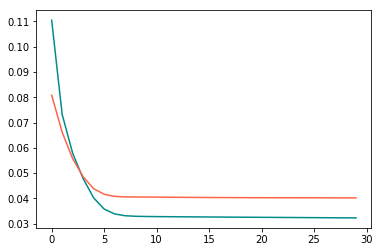

In [34]:
input_size=1
hidden_size=24
num_layers=2
lstm=LSTM(input_size,hidden_size)

learning_rate=0.0001
max_grad_norm=5
loss_fn = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=0.000001)

batch_size = 8
num_epochs = 30 #3
# num_sequences = x_train_set.size(0)
# num_batches = num_sequences //batch_size

checkpoint_freq = 10
path = './'

train_losses=[]
valid_losses=[]

print("Training model for {} epoch".format(num_epochs))
for epoch in range(num_epochs):
#     total_loss = 0

    # Shuffle input and target sequences.
    idx = torch.randperm(x_train_set.size(0))
    x = x_train_set[idx]
    y = y_train_set[idx]
    
    train_loss=train(lstm,x_train_set,y_train_set,optimizer,batch_size,epoch)
    valid_loss=eval(lstm,x_valid_set,y_valid_set,optimizer,batch_size)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, lstm, path)
        
# Last checkpoint
save_model(num_epochs, lstm, path)
    
print("\n\n\nOptimization ended.\n")

plt.plot(train_losses, color="darkcyan", label="train")
plt.plot(valid_losses, color="tomato",label="validation")
plt.show()

In [28]:
def predict_one_hour(model,x_valid_set,input_size,num_steps):
    predictions=torch.zeros(num_steps)
    for i, x in enumerate(x_valid_set):
        hidden=model.init_hidden(1)
        y_pred,_,_=model(x.contiguous().view(-1, 1, input_size),hidden)
        predictions[i]=y_pred
    return predictions

In [29]:
one_step_predictions = predict_one_hour(lstm, x_valid_set, input_size, y_valid_set.size(0))

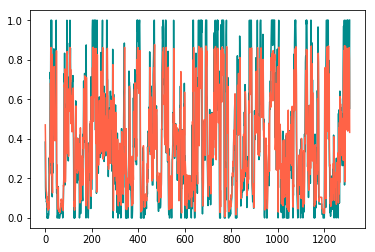

In [30]:
plt.plot(y_valid_set.data.numpy(),color='darkcyan')
plt.plot(one_step_predictions.data.numpy(),color='tomato')
plt.show()